In [29]:
from pathlib import Path

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.metrics import classification_report
plt.style.use('dark_background')

In [30]:
import scipy.stats
from sklearn.metrics import mean_squared_error

plots_dir = Path.cwd() / "../plots"
results_dir = Path.cwd() / "../results/intensity_classification_per_mol"


## Evaluation of classification

In [31]:
# result_filename = "intensity_classification_all_feat.csv"
# result_filename = "intensity_classification_fingerprints_feat.csv"
# result_filename = "intensity_classification_mol_feat.csv"
# result_filename = "intensity_classification_one_random_mol_feat.csv"

filenames = {
    "all_feat": "intensity_classification_all_feat.csv",
    "fingerprints_feat": "intensity_classification_fingerprints_feat.csv",
    "mol_feat": "intensity_classification_mol_feat.csv",
    "random_feat": "intensity_classification_one_random_mol_feat.csv",
    # "no_feat": "intensity_classification_no_features.csv",
}

# detection_results = pd.read_csv(results_dir / result_filename, index_col = 0)
# detection_results = detection_results.rename(columns={'Matrix short': 'matrix',
#                                                       'Polarity': 'polarity'})
# detection_results



In [32]:
metric = "macro_avg_f1_score"

# compute Spearman's/Pearson's correlation and mean squared error for each matrix/polarity/regressor
score_cols = ['not_det_precision', 'not_det_recall', 'not_det_f1', 'not_detected',
                                            'det_precision', 'det_recall', 'det_f1', 'detected', 'macro_avg_f1_score']
models_results = pd.DataFrame()
model_metrics = pd.DataFrame(columns = ['matrix', 'polarity', 'model_type', 'train_setup'] + score_cols)
model_performance = pd.DataFrame()
counter = 0

for training_setup in filenames:
    result_filename = filenames[training_setup]
    loc_models_results = pd.read_csv(results_dir / result_filename, index_col = 0)

    # -----------------------------------------
    # Add extra baseline randomly guessing:
    # -----------------------------------------

    baseline_results = loc_models_results.drop(columns=["classifier", "prediction", "fold"]).drop_duplicates().reset_index(drop=True)
    baseline_results["prediction"] = 0
    baseline_results["fold"] = 0
    baseline_results["classifier"] = "random_guess"

    for (matrix, polarity), rows in baseline_results.groupby(['matrix', 'polarity']):
        val_counts = rows.observed_value.value_counts()
        val_counts = val_counts / float(val_counts.sum())
        rand_prediction = np.random.choice(val_counts.index.to_numpy(), size=rows.observed_value.shape,p=val_counts.to_numpy())
        baseline_results.loc[rows.index.to_list(), "prediction"] = rand_prediction

    loc_models_results = pd.concat([loc_models_results, baseline_results])


    for (matrix, polarity, classifier), rows in loc_models_results.groupby(['matrix', 'polarity', 'classifier']):

        clf_report = classification_report(rows.observed_value, rows.prediction, output_dict = True, zero_division=0)
        if rows.observed_value.max() == 0:
            print("no detection!")
        model_metrics.loc[counter] = [matrix, polarity, classifier, training_setup,
                                          clf_report['0']['precision'], clf_report['0']['recall'],
                                          clf_report['0']['f1-score'], clf_report['0']['support'],
                                          clf_report['1']['precision'], clf_report['1']['recall'],
                                          clf_report['1']['f1-score'], clf_report['1']['support'],
                                          clf_report['macro avg']['f1-score']
                                          ]
        counter += 1

    loc_models_results["train_setup"] = training_setup
    models_results = pd.concat([models_results, loc_models_results])

    # FInd best model across matrices:
    loc_model_performance = pd.DataFrame()
    for (matrix, polarity), rows in model_metrics.groupby(['matrix', 'polarity']):
        rows["difference"] = rows[metric] - rows[metric].max()
        loc_model_performance = pd.concat([loc_model_performance, rows[["model_type", "difference"]]])

    loc_model_performance = loc_model_performance.groupby(["model_type"]).sum()
    loc_model_performance["train_setup"] = training_setup
    model_performance = pd.concat([model_performance, loc_model_performance])



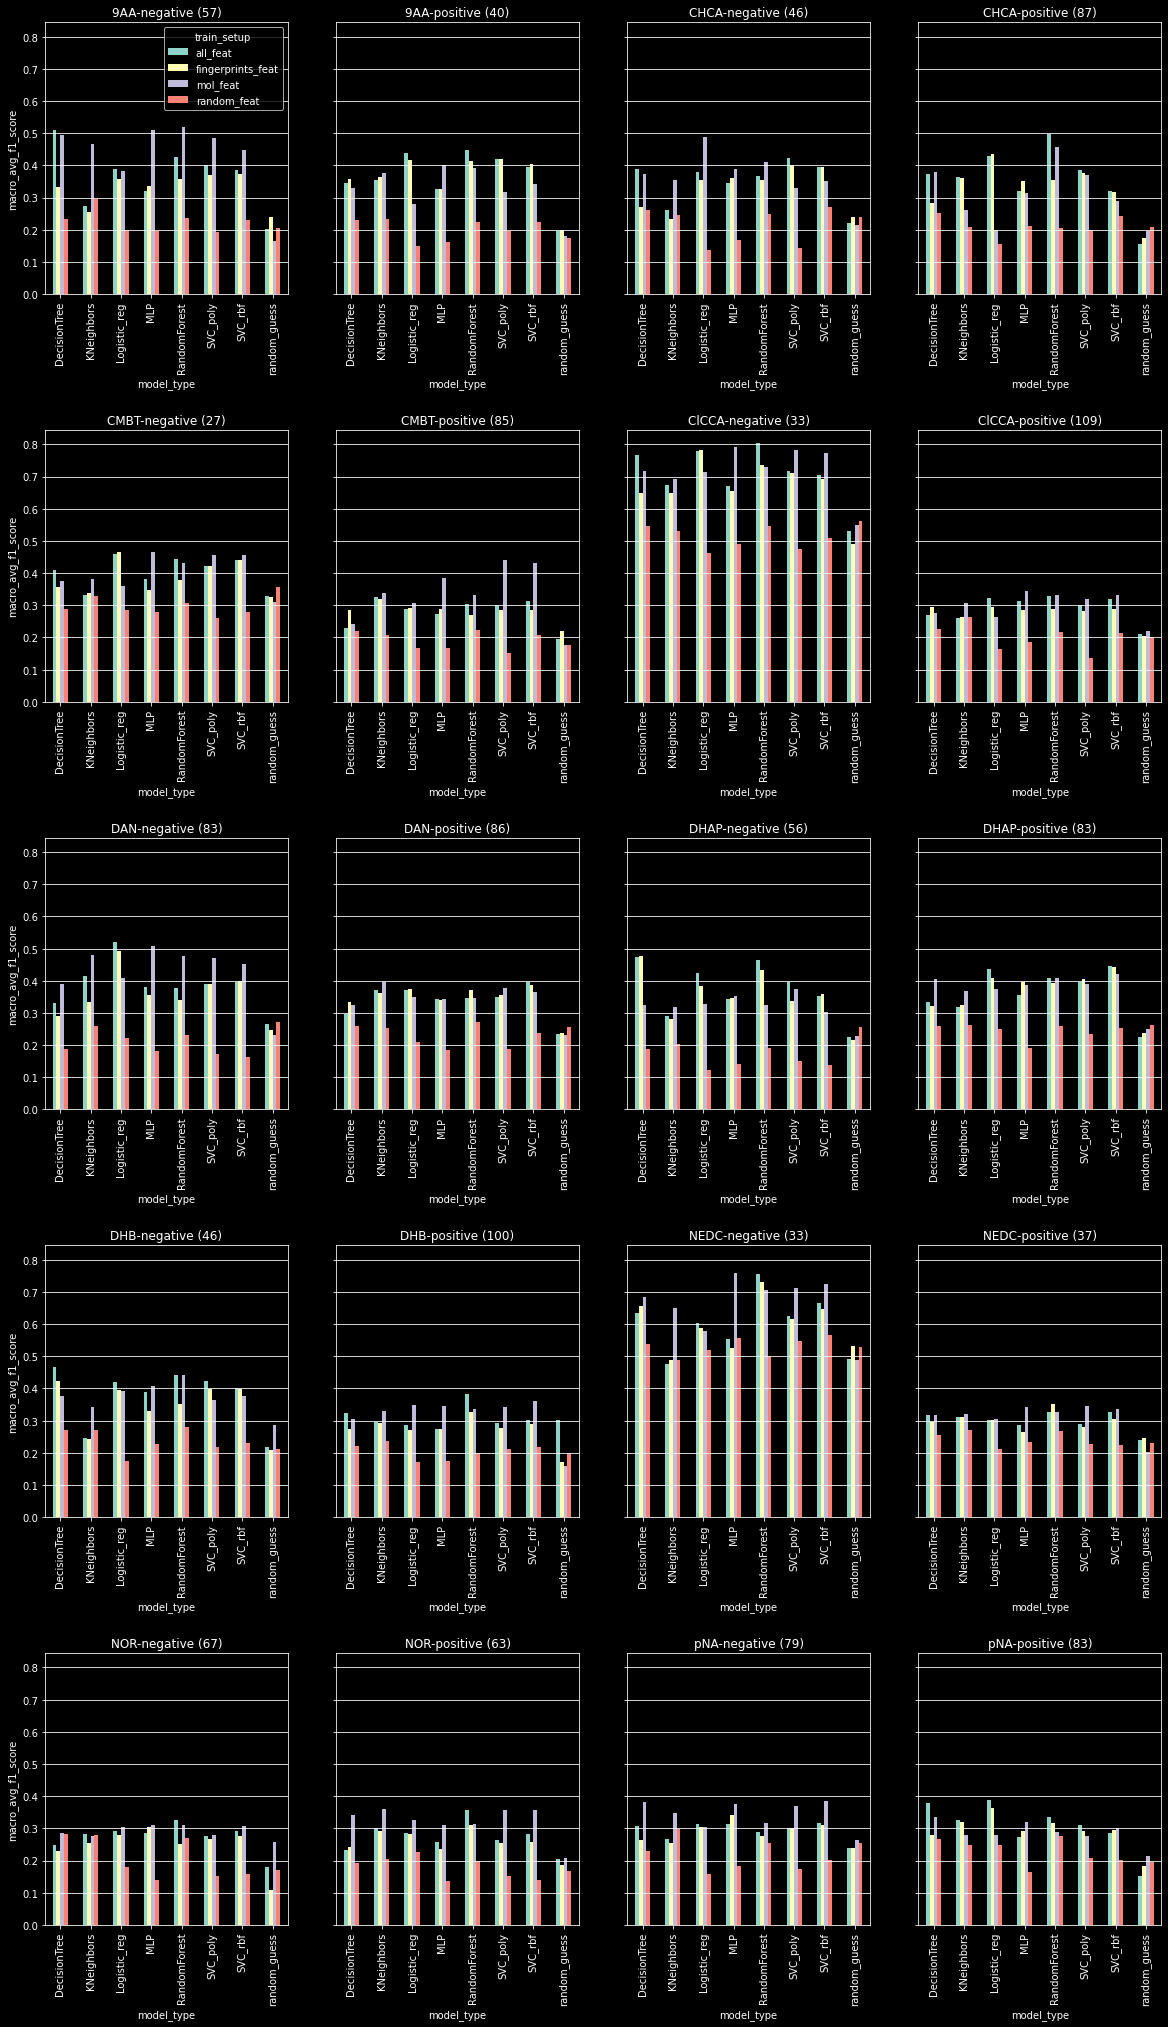

In [33]:

fig, axes = plt.subplots(ncols=4,nrows=5, sharey=True, figsize= (20, 35))
ax_list = axes.flat

# metric = "Spearman's R"
#metric = "RMSE"

i = 0
for (matrix, polarity), rows in model_metrics.groupby(['matrix', 'polarity']):
    nb_obs = rows['detected'].drop_duplicates().values[0]
    rows = rows.set_index(["model_type", 'train_setup'], drop = True).sort_values( by = ["model_type", metric])
    rows = rows.unstack("train_setup")
    rows[metric].plot.bar(ax = ax_list[i], title=f"{matrix}-{polarity} ({nb_obs})")
    ax_list[i].set_ylabel(metric)
    ax_list[i].grid(axis='y')
    if i != 0:
        ax_list[i].legend(loc="lower right")
        ax_list[i].get_legend().set_visible(False)
        # ax_list[i].get_legend().set_visible(False)
    i+=1

plt.subplots_adjust(hspace=0.5)
plt.show()


<AxesSubplot:xlabel='model_type'>

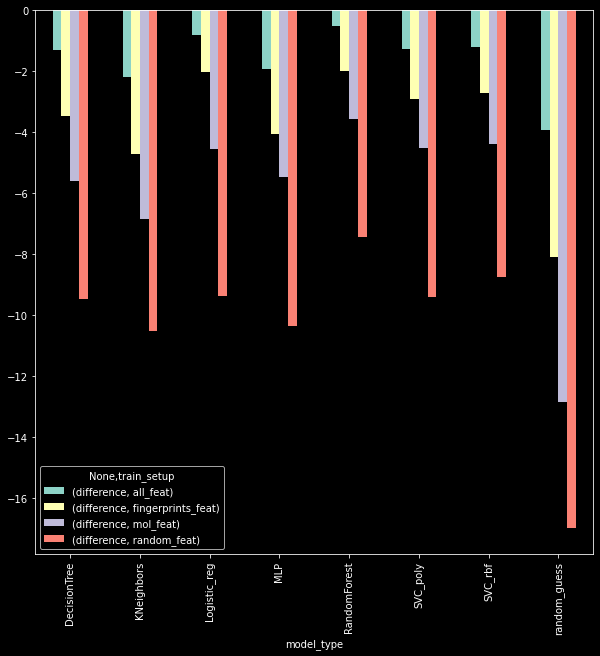

In [34]:
model_performance.reset_index().sort_values(by="difference").set_index(["model_type", "train_setup"], drop=True).unstack("train_setup").plot.bar(figsize=(10,10))
# model_performance




### Find best model according to avg-f1

In [14]:
# FInd best model across matrices:
metric = "macro_avg_f1_score"
classifier_performance = pd.DataFrame()

for (matrix, polarity), rows in detection_metrics.groupby(['matrix', 'polarity']):
    rows["difference"] = rows[metric] - rows[metric].max()
    classifier_performance = pd.concat([classifier_performance, rows[["classifier", "difference"]]])

classifier_performance = classifier_performance.groupby(["classifier"]).mean()
classifier_performance.sort_values("difference", ascending=False)


,difference
classifier,
MLP,-0.027207
RandomForest,-0.035817
SVC_poly,-0.037448
SVC_rbf,-0.039761
DecisionTree,-0.062985
KNeighbors,-0.063138
Logistic_reg,-0.081091


### Std of scores over folds:

In [16]:
from sklearn.metrics import classification_report

detection_metrics_over_fold = pd.DataFrame(columns = ['matrix', 'polarity', 'classifier', 'fold'] + score_cols)

counter = 0
for (matrix, polarity, classifier, fold), rows in detection_results.groupby(['matrix', 'polarity', 'classifier', 'fold']):
    clf_report = classification_report(rows.observed_value, rows.prediction, output_dict = True, zero_division=0)
    if rows.observed_value.max() == 0:
        print("no detection! Aborting")
        break
    detection_metrics_over_fold.loc[counter] = [matrix, polarity, classifier, fold,
                                      clf_report['0']['precision'], clf_report['0']['recall'],
                                      clf_report['0']['f1-score'], clf_report['0']['support'],
                                      clf_report['1']['precision'], clf_report['1']['recall'],
                                      clf_report['1']['f1-score'], clf_report['1']['support'],
                                      clf_report['macro avg']['f1-score']
                                      ]
    counter += 1

# Now compute std over folds:
detection_metrics_over_fold = detection_metrics_over_fold.groupby(['matrix', 'polarity', 'classifier'], as_index=False)[score_cols].std()




,matrix,polarity,classifier,not_det_precision,not_det_recall,not_det_f1,not_detected,det_precision,det_recall,det_f1,detected,macro_avg_f1_score
3,9AA,negative,MLP,0.188702,0.146734,0.104794,0.816497,0.154161,0.155754,0.116132,0.483046,0.106233
10,9AA,positive,MLP,0.080125,0.107709,0.072706,0.918937,0.135458,0.197203,0.149021,0.000000,0.112516
17,CHCA,negative,MLP,0.092725,0.122856,0.086527,0.471405,0.235859,0.320416,0.250196,0.516398,0.127010
24,CHCA,positive,MLP,0.311948,0.335640,0.269131,0.527046,0.222730,0.159632,0.155142,0.483046,0.096825
31,CMBT,negative,MLP,0.066161,0.115705,0.074259,0.316228,0.322343,0.304797,0.269005,0.483046,0.164502
38,CMBT,positive,MLP,0.141696,0.177221,0.152798,1.619328,0.150715,0.094017,0.115922,0.527046,0.129120
45,ClCCA,negative,MLP,0.056970,0.077490,0.049531,0.516398,0.183490,0.237171,0.182093,0.483046,0.112566
52,ClCCA,positive,MLP,0.151138,0.274986,0.188235,0.516398,0.111824,0.108758,0.100814,0.316228,0.143953
59,DAN,negative,MLP,0.177639,0.178421,0.143153,0.666667,0.176595,0.197181,0.152219,0.483046,0.175809
66,DAN,positive,MLP,0.162874,0.197306,0.131480,0.966092,0.195631,0.205198,0.179011,0.516398,0.144297


In [19]:
detection_metrics_over_fold[detection_metrics_over_fold.classifier == "MLP"]

,matrix,polarity,classifier,not_det_precision,not_det_recall,not_det_f1,not_detected,det_precision,det_recall,det_f1,detected,macro_avg_f1_score
3,9AA,negative,MLP,0.188702,0.146734,0.104794,0.816497,0.154161,0.155754,0.116132,0.483046,0.106233
10,9AA,positive,MLP,0.080125,0.107709,0.072706,0.918937,0.135458,0.197203,0.149021,0.000000,0.112516
17,CHCA,negative,MLP,0.092725,0.122856,0.086527,0.471405,0.235859,0.320416,0.250196,0.516398,0.127010
24,CHCA,positive,MLP,0.311948,0.335640,0.269131,0.527046,0.222730,0.159632,0.155142,0.483046,0.096825
31,CMBT,negative,MLP,0.066161,0.115705,0.074259,0.316228,0.322343,0.304797,0.269005,0.483046,0.164502
38,CMBT,positive,MLP,0.141696,0.177221,0.152798,1.619328,0.150715,0.094017,0.115922,0.527046,0.129120
45,ClCCA,negative,MLP,0.056970,0.077490,0.049531,0.516398,0.183490,0.237171,0.182093,0.483046,0.112566
52,ClCCA,positive,MLP,0.151138,0.274986,0.188235,0.516398,0.111824,0.108758,0.100814,0.316228,0.143953
59,DAN,negative,MLP,0.177639,0.178421,0.143153,0.666667,0.176595,0.197181,0.152219,0.483046,0.175809
66,DAN,positive,MLP,0.162874,0.197306,0.131480,0.966092,0.195631,0.205198,0.179011,0.516398,0.144297
